# cora_geniepath_v1_loss

Epoch: 001,train_loss:1.0991530418395996, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 002,train_loss:1.0979838371276855, Train: 0.3333, Val: 0.3900, Test: 0.4130
Epoch: 003,train_loss:1.0970289707183838, Train: 0.5167, Val: 0.4280, Test: 0.4200
Epoch: 004,train_loss:1.0957348346710205, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 005,train_loss:1.0932832956314087, Train: 0.6333, Val: 0.5360, Test: 0.5060
Epoch: 006,train_loss:1.087320327758789, Train: 0.8167, Val: 0.5180, Test: 0.5080
Epoch: 007,train_loss:1.0717315673828125, Train: 0.7667, Val: 0.5800, Test: 0.5830
Epoch: 008,train_loss:1.027691125869751, Train: 0.8000, Val: 0.5780, Test: 0.5630
Epoch: 009,train_loss:0.9052249193191528, Train: 0.6833, Val: 0.5680, Test: 0.5320
Epoch: 010,train_loss:0.6782538294792175, Train: 0.7000, Val: 0.5520, Test: 0.5310
Epoch: 011,train_loss:0.5704870223999023, Train: 0.6500, Val: 0.5500, Test: 0.5240
Epoch: 012,train_loss:0.7353090643882751, Train: 0.7167, Val: 0.5920, Test: 0.5600
Epoch:

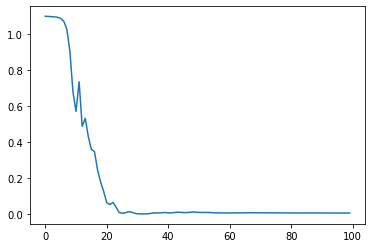

CPU times: user 17.2 s, sys: 5.04 s, total: 22.3 s
Wall time: 19 s


4755003

In [27]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Pubmed'
path = osp.join('./', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

dim = dataset.num_features
lstm_hidden = dataset.num_features
layer_num = 2#这只要超过2，就没有效果了，准确率会很低


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = GATConv(in_dim, out_dim, heads=1)#这里in_dim和out_dim都=dim=256
        # self.gatconv = GATConv(256, 256, heads=1)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(in_dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()

#     total_loss = 0
    # for data in train_loader:
    # num_graphs = data.num_graphs
    # data.batch = None
    # data = data.to(device)
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = F.cross_entropy(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # total_loss += loss.item() * num_graphs
#     total_loss += loss.item() 
    loss.backward()
    optimizer.step()
    return loss.item()


# def test(loader):
#     model.eval()

#     ys, preds = [], []
#     for data in loader:
#         ys.append(data.y)
#         with torch.no_grad():
#             out = model(data.x.to(device), data.edge_index.to(device))
#         preds.append((out > 0).float().cpu())

#     y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
#     return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_pub_genie=[]
for epoch in range(1, 101):
    loss = train()
    losslist_pub_genie.append(loss)
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pub_genie)
plt.show()
sum([torch.numel(param) for param in model.parameters()])

# cora_AGNN

Epoch: 001,Train_loss:1.9562064409255981, Train: 0.1429, Val: 0.1560, Test: 0.1440
Epoch: 002,Train_loss:1.9530179500579834, Train: 0.1429, Val: 0.1560, Test: 0.1440
Epoch: 003,Train_loss:1.948250412940979, Train: 0.1429, Val: 0.1560, Test: 0.1440
Epoch: 004,Train_loss:1.9468544721603394, Train: 0.1500, Val: 0.1580, Test: 0.1490
Epoch: 005,Train_loss:1.9423749446868896, Train: 0.1929, Val: 0.1620, Test: 0.1590
Epoch: 006,Train_loss:1.937199592590332, Train: 0.2071, Val: 0.1920, Test: 0.1930
Epoch: 007,Train_loss:1.9309495687484741, Train: 0.2214, Val: 0.2300, Test: 0.2220
Epoch: 008,Train_loss:1.9293171167373657, Train: 0.2571, Val: 0.2560, Test: 0.2410
Epoch: 009,Train_loss:1.9277393817901611, Train: 0.2786, Val: 0.2960, Test: 0.2840
Epoch: 010,Train_loss:1.923215389251709, Train: 0.4000, Val: 0.3520, Test: 0.3330
Epoch: 011,Train_loss:1.9103398323059082, Train: 0.6714, Val: 0.4820, Test: 0.4640
Epoch: 012,Train_loss:1.912225604057312, Train: 0.8143, Val: 0.6140, Test: 0.5960
Epoch: 0

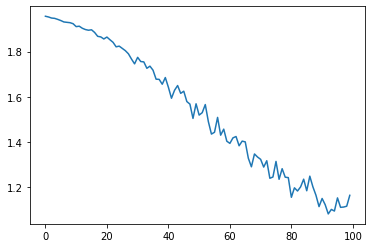

CPU times: user 4.13 s, sys: 240 ms, total: 4.37 s
Wall time: 2.04 s


23064

In [7]:
%%time
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import AGNNConv

dataset = 'Cora'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = torch.nn.Linear(dataset.num_features, 16)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(16, dataset.num_classes)

    def forward(self):
        x = F.dropout(data.x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.prop1(x, data.edge_index)
        x = self.prop2(x, data.edge_index)
        x = F.dropout(x, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    loss=F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


best_val_acc = test_acc = 0
losslist_pub_agnn=[]
for epoch in range(1, 101):
    loss=train()
    losslist_pub_agnn.append(loss)
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d},Train_loss:{}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch,loss, train_acc, best_val_acc, test_acc))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pub_agnn)
plt.show()
sum([torch.numel(param) for param in model.parameters()])

# cora_GAT 

Epoch: 001,Train_loss:1.9466607570648193, Train: 0.1714, Val: 0.0940, Test: 0.0990
Epoch: 002,Train_loss:1.9415925741195679, Train: 0.4429, Val: 0.2360, Test: 0.2570
Epoch: 003,Train_loss:1.9331802129745483, Train: 0.5143, Val: 0.3080, Test: 0.2960
Epoch: 004,Train_loss:1.925504207611084, Train: 0.5214, Val: 0.3520, Test: 0.3430
Epoch: 005,Train_loss:1.915833592414856, Train: 0.5929, Val: 0.3680, Test: 0.3770
Epoch: 006,Train_loss:1.9111164808273315, Train: 0.6714, Val: 0.4200, Test: 0.4310
Epoch: 007,Train_loss:1.9063152074813843, Train: 0.8000, Val: 0.4820, Test: 0.5170
Epoch: 008,Train_loss:1.9026192426681519, Train: 0.8286, Val: 0.5400, Test: 0.5550
Epoch: 009,Train_loss:1.9019683599472046, Train: 0.8643, Val: 0.5980, Test: 0.6040
Epoch: 010,Train_loss:1.8930855989456177, Train: 0.8357, Val: 0.6300, Test: 0.6310
Epoch: 011,Train_loss:1.8682039976119995, Train: 0.8571, Val: 0.6800, Test: 0.6670
Epoch: 012,Train_loss:1.8683072328567505, Train: 0.8643, Val: 0.7060, Test: 0.6860
Epoch:

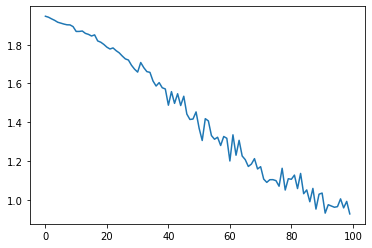

CPU times: user 4.83 s, sys: 204 ms, total: 5.03 s
Wall time: 2.32 s


92373

In [5]:
%%time
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv

dataset = 'Cora'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(
            8 * 8, dataset.num_classes, heads=1, concat=True, dropout=0.6)

    def forward(self):
        x = F.dropout(data.x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
#     total_loss = 0

    optimizer.zero_grad()
    #损失函数NLLLoss() 的 输入 是一个对数概率向量和一个目标标签. 它不会为我们计算对数概率，
    # 适合最后一层是log_softmax()的网络（28行）. 损失函数 CrossEntropyLoss() 与 NLLLoss() 类似, 
    # 唯一的不同是它为我们去做 softmax.可以理解为：
    # CrossEntropyLoss()=log_softmax() + NLLLoss() 

    #model()每个点都给出预测结果，但这里只取train_mask
    loss=F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
#     total_loss+=loss.item()
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_pub_GAT=[]
for epoch in range(1, 101):
    loss=train()
    losslist_pub_GAT.append(loss)
    log = 'Epoch: {:03d},Train_loss:{}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pub_GAT)
plt.show()
sum([torch.numel(param) for param in model.parameters()])

In [106]:
for _, mask in data('train_mask', 'val_mask', 'test_mask'):
    print(mask.sum().item())
data.train_mask.sum().item()

140
500
1000


140

# cora_sgeniepath_AGNN

Epoch: 001,train_loss:1.098610520362854, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 002,train_loss:1.0982882976531982, Train: 0.3833, Val: 0.2020, Test: 0.1840
Epoch: 003,train_loss:1.098037600517273, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 004,train_loss:1.0977457761764526, Train: 0.3333, Val: 0.1960, Test: 0.1800
Epoch: 005,train_loss:1.0973056554794312, Train: 0.3667, Val: 0.1980, Test: 0.1820
Epoch: 006,train_loss:1.096553921699524, Train: 0.6167, Val: 0.3980, Test: 0.4020
Epoch: 007,train_loss:1.0951565504074097, Train: 0.8333, Val: 0.6300, Test: 0.6190
Epoch: 008,train_loss:1.0923151969909668, Train: 0.9167, Val: 0.6840, Test: 0.6410
Epoch: 009,train_loss:1.086045503616333, Train: 0.7667, Val: 0.5940, Test: 0.5680
Epoch: 010,train_loss:1.071515679359436, Train: 0.6833, Val: 0.5780, Test: 0.5450
Epoch: 011,train_loss:1.038204312324524, Train: 0.6667, Val: 0.5800, Test: 0.5440
Epoch: 012,train_loss:0.968344509601593, Train: 0.6667, Val: 0.5800, Test: 0.5440
Epoch: 013,

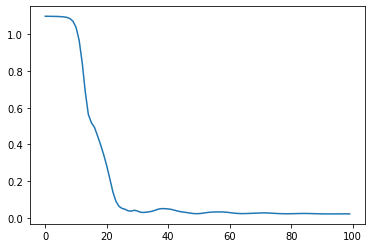

CPU times: user 26.3 s, sys: 9.46 s, total: 35.8 s
Wall time: 30.8 s


6252006

In [1]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import AGNNConv

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Pubmed'
path = osp.join('./', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

dim = dataset.num_features
lstm_hidden = dataset.num_features
layer_num = 3#这只要超过2，就没有效果了，准确率会很低


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
#         self.gatconv = GATConv(in_dim, out_dim, heads=1)#这里in_dim和out_dim都=dim=256
        self.gatconv = AGNNConv(requires_grad=True)

        # self.gatconv = GATConv(256, 256, heads=1)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(in_dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask]) 
    loss.backward()
    optimizer.step()
    return loss 


# def test(loader):
#     model.eval()

#     ys, preds = [], []
#     for data in loader:
#         ys.append(data.y)
#         with torch.no_grad():
#             out = model(data.x.to(device), data.edge_index.to(device))
#         preds.append((out > 0).float().cpu())

#     y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
#     return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_pubmed_sgenagnn=[]
for epoch in range(1, 101):
    loss = train()
    losslist_pubmed_sgenagnn.append(loss)
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pubmed_sgenagnn)
plt.show()
sum([torch.numel(param) for param in model.parameters()])

# 加dropout而且embedding到128维，Cora数据集有效

In [36]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv,AGNNConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Cora'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# dim = dataset.num_features
# lstm_hidden = dataset.num_features
dim = 128
lstm_hidden = 128
layer_num = 2  #pubmed为3效果比较好，cora不能超过2,Citeseer不能超过1


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        # self.gatconv = AGNNConv(requires_grad=True)
        self.gatconv = GATConv(in_dim, out_dim,dropout=0.4, heads=1)#这里in_dim和out_dim都=dim=256

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x=F.dropout(x, p=0.4, training=self.training)

        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x=F.dropout(x, p=0.4, training=self.training)

        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = loss_op(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        a=logits[mask]
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_cora_geniepath,testacclist_cora_geniepath=[],[]
for epoch in range(1, 1001):
    loss = train()
    losslist_cora_geniepath.append(loss)
    testacclist_cora_geniepath.append(test()[2])
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{:.7f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
# from matplotlib import pyplot as plt 
# %matplotlib inline
# f, ax = plt.subplots(1,2)

# ax[0][0].plot(losslist_cora_geniepath,label="losslist_cora_geniepath")
# ax[0][1].plot(testacclist_cora_geniepath,label="testacclist_cora_geniepath")
# plt.legend(loc=0, ncol=1) 
# plt.show()



"""
1000轮cora数据集效果
Epoch: 979,train_loss:0.1637752, Train: 1.0000, Val: 0.7000, Test: 0.7280
Epoch: 980,train_loss:0.0791690, Train: 1.0000, Val: 0.7120, Test: 0.7390
Epoch: 981,train_loss:0.0635783, Train: 1.0000, Val: 0.7240, Test: 0.7450
Epoch: 982,train_loss:0.0318759, Train: 1.0000, Val: 0.7340, Test: 0.7460
Epoch: 983,train_loss:0.0955521, Train: 1.0000, Val: 0.7500, Test: 0.7570
Epoch: 984,train_loss:0.0810624, Train: 1.0000, Val: 0.7500, Test: 0.7670
Epoch: 985,train_loss:0.0891033, Train: 1.0000, Val: 0.7640, Test: 0.7750
Epoch: 986,train_loss:0.0739494, Train: 1.0000, Val: 0.7600, Test: 0.7830
Epoch: 987,train_loss:0.0990233, Train: 1.0000, Val: 0.7560, Test: 0.7770
Epoch: 988,train_loss:0.0988771, Train: 1.0000, Val: 0.7520, Test: 0.7710
Epoch: 989,train_loss:0.0732601, Train: 1.0000, Val: 0.7520, Test: 0.7650
Epoch: 990,train_loss:0.0788579, Train: 1.0000, Val: 0.7640, Test: 0.7680
Epoch: 991,train_loss:0.0499137, Train: 1.0000, Val: 0.7620, Test: 0.7670
Epoch: 992,train_loss:0.0951503, Train: 1.0000, Val: 0.7540, Test: 0.7560
Epoch: 993,train_loss:0.1640868, Train: 1.0000, Val: 0.7500, Test: 0.7520
Epoch: 994,train_loss:0.1025555, Train: 1.0000, Val: 0.7420, Test: 0.7400
Epoch: 995,train_loss:0.0693817, Train: 1.0000, Val: 0.7480, Test: 0.7430
Epoch: 996,train_loss:0.0883153, Train: 1.0000, Val: 0.7560, Test: 0.7580
Epoch: 997,train_loss:0.1922379, Train: 1.0000, Val: 0.7540, Test: 0.7570
Epoch: 998,train_loss:0.0917486, Train: 1.0000, Val: 0.7540, Test: 0.7560
Epoch: 999,train_loss:0.1085564, Train: 1.0000, Val: 0.7500, Test: 0.7570
Epoch: 1000,train_loss:0.0600472, Train: 1.0000, Val: 0.7560, Test: 0.7610
[1]    5346 terminated  env PYTHONIOENCODING=UTF-8 PYTHONUNBUFFERED=1   --default --client --host    
"""



Epoch: 001,train_loss:1.9466422, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 002,train_loss:1.9461576, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 003,train_loss:1.9460465, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 004,train_loss:1.9459246, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 005,train_loss:1.9456053, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 006,train_loss:1.9456373, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 007,train_loss:1.9456203, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 008,train_loss:1.9454428, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 009,train_loss:1.9451236, Train: 0.1429, Val: 0.1620, Test: 0.1490
Epoch: 010,train_loss:1.9455793, Train: 0.1500, Val: 0.1640, Test: 0.1550
Epoch: 011,train_loss:1.9453348, Train: 0.1714, Val: 0.1600, Test: 0.1800
Epoch: 012,train_loss:1.9451344, Train: 0.1429, Val: 0.3160, Test: 0.3190
Epoch: 013,train_loss:1.9453088, Train: 0.1429, Val: 0.3160, Test: 0.3190
Epoch: 014,train_loss:1.9454287, Train

'\n1000轮cora数据集效果\nEpoch: 979,train_loss:0.1637752, Train: 1.0000, Val: 0.7000, Test: 0.7280\nEpoch: 980,train_loss:0.0791690, Train: 1.0000, Val: 0.7120, Test: 0.7390\nEpoch: 981,train_loss:0.0635783, Train: 1.0000, Val: 0.7240, Test: 0.7450\nEpoch: 982,train_loss:0.0318759, Train: 1.0000, Val: 0.7340, Test: 0.7460\nEpoch: 983,train_loss:0.0955521, Train: 1.0000, Val: 0.7500, Test: 0.7570\nEpoch: 984,train_loss:0.0810624, Train: 1.0000, Val: 0.7500, Test: 0.7670\nEpoch: 985,train_loss:0.0891033, Train: 1.0000, Val: 0.7640, Test: 0.7750\nEpoch: 986,train_loss:0.0739494, Train: 1.0000, Val: 0.7600, Test: 0.7830\nEpoch: 987,train_loss:0.0990233, Train: 1.0000, Val: 0.7560, Test: 0.7770\nEpoch: 988,train_loss:0.0988771, Train: 1.0000, Val: 0.7520, Test: 0.7710\nEpoch: 989,train_loss:0.0732601, Train: 1.0000, Val: 0.7520, Test: 0.7650\nEpoch: 990,train_loss:0.0788579, Train: 1.0000, Val: 0.7640, Test: 0.7680\nEpoch: 991,train_loss:0.0499137, Train: 1.0000, Val: 0.7620, Test: 0.7670\nEpoch:

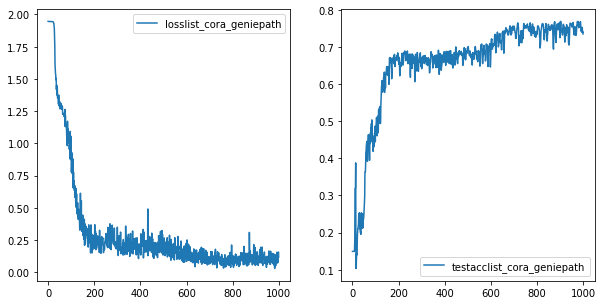

In [37]:
from matplotlib import pyplot as plt 
%matplotlib inline
f, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)

ax[0][0].plot(losslist_cora_geniepath,label="losslist_cora_geniepath")
ax[0][0].legend(loc=0, ncol=1) 
ax[0][1].plot(testacclist_cora_geniepath,label="testacclist_cora_geniepath")
ax[0][1].legend(loc=0, ncol=1) 
# ax1 = plt.subplot(121)
# ax2=plt.subplot(122)
# ax1.plot(losslist_cora_geniepath,label="losslist_cora_geniepath")
# ax1.legend()
# ax2.plot(testacclist_cora_geniepath,label="testacclist_cora_geniepath")
# ax2.legend()

plt.show()


# 画图

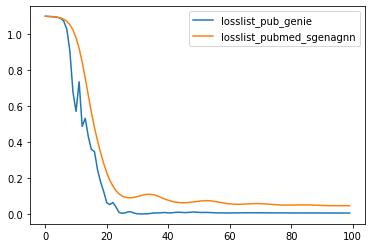

In [33]:
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pub_genie,label="losslist_pub_genie")

plt.plot(losslist_pubmed_sgenagnn,label="losslist_pubmed_sgenagnn")
# plt.plot(losslist_pub_agnn,label="losslist_pub_agnn")
# plt.plot(losslist_pub_GAT,label="losslist_pub_GAT")


plt.legend(loc=0, ncol=1) 
plt.savefig('./pubmed数据集对比.jpg')
plt.show()

In [ ]:
# from matplotlib import pyplot as plt
# import numpy as np

# x = np.linspace(1, 100, num= 25, endpoint = True)

# def y_subplot(x,i):
#     return np.cos(i * np.pi *x)

# #使用subplots 画图
# f, ax = plt.subplots(2,2)
# #type(f) #matplotlib.figure.Figure

# style_list = ["g+-", "r*-", "b.-", "yo-"]
# ax[0][0].plot(x, y_subplot(x, 1), style_list[0])
# ax[0][1].plot(x, y_subplot(x, 2), style_list[1])
# ax[1][0].plot(x, y_subplot(x, 3), style_list[2])
# ax[1][1].plot(x, y_subplot(x, 4), style_list[3],label="111")

# plt.show()
# # fig = plt.figure()
# # for i in range(1,5):
# #     ax = fig.add_subplot(2,2,i)
# #     ax.plot(x, y_subplot(x,i), style_list[i -1])

# # plt.show()
# x